# Estimating $p(T)$ from APLAWD

- APLAWD database [@Lindsey1987]. British English.

- APLAWD GCI markings [@Serwy2017]. Very high-quality, hand-corrected.

- Time shift of WAV vs. EGG is ~ 0.95 msec [@Naylor2007]. **OK: Implemented.**

## Note about jitter

We model the 'true' pitch periods by a GP with $\sigma^2_n$ (i.e., `noise_sigma**2`) term which, when fitted, predicts unrealistically high voice jitter. This is because it has picked up all kinds of other effects in the data, working as a 'shock absorber' to keep the other GP parameters unharmed. We acknowledge this and during inference of the latent GP function replace this $\sigma_n^2$ noise term by zero. We still have inherent jitter in the process which we calculate below. It is likely that the jitter has been learned to some degree by the kernel because the `Matern32Kernel` is preferred over `Matern52Kernel` and `SqExponentialKernel`.

Note: we could circumvent this by using a Student-T process instead of a GP, which would absorp these shocks (i.e., outliers) for us, resulting in a more realistic $\sigma_n^2$ value which would relative more directly to jitter.

## Can we use `TIMIT-voiced`?

No.

The TIMIT-voiced database does not have GCI information; the frames nearly constant-length and give only voiced/unvoiced information.
In addition, I could not find a reference, and I think these values have been auto-generated and not manually verified.

In [1]:
%run init.ipy

from lib import aplawd
from lib import praat
from lib import util
from dgf import bijectors
from dgf import isokernels
from dgf import core
from lib import constants
from dgf.prior import period

import dynesty
import pandas as pd
import warnings
import itertools
import scipy.stats
import multiprocessing

2022-12-16 14:32:33.872594: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-16 14:32:33.872653: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-16 14:32:33.872658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Plot samples from APLAWD

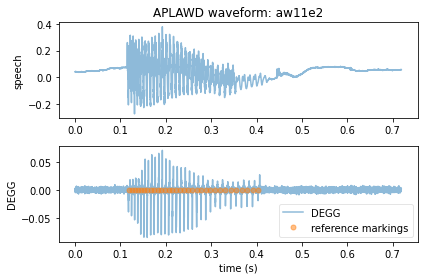

In [2]:
recordings = aplawd.APLAWD(__datadir__('APLAWDW/dataset'))
markings = aplawd.APLAWD_Markings(__datadir__('APLAWDW/markings/aplawd_gci'))

def plot_recording_and_degg(recordings, markings, key):
    """Adapted from https://github.com/serwy/aplawdw/blob/master/demo_001.py"""
    aplawd_db = recordings
    markings_db = markings

    key = np.random.choice(aplawd_db.keys())

    recording = aplawd_db.load_shifted(key)
    recording_gci = markings_db.load(recording.name)

    ax = plt.subplot(211)
    t = np.arange(len(recording.s)) / recording.fs
    plt.plot(t, recording.s, alpha=0.5)
    plt.ylabel('speech')
    plt.title('APLAWD waveform: %s' % recording.name)

    plt.subplot(212, sharex=ax)
    t = np.arange(len(recording.d)) / recording.fs

    plt.plot(t, recording.d, alpha=0.5, label='DEGG')

    plt.plot(t[recording_gci], 0*recording_gci, 'o', ms=5, alpha=0.5,
             label='reference markings')

    plt.legend(loc='lower right', fancybox=True, framealpha=0.5)
    plt.ylabel('DEGG')
    plt.xlabel('time (s)')

    plt.tight_layout()

plot_recording_and_degg(recordings, markings, recordings.random_key())

## Illustrate the data gathering process: `period.yield_training_pairs()`

We pair the manually checked markings with Praat's pulse estimates.
Each recording is split into groups of voiced markings and those groups are matched and aligned with Praat's pulse estimates.

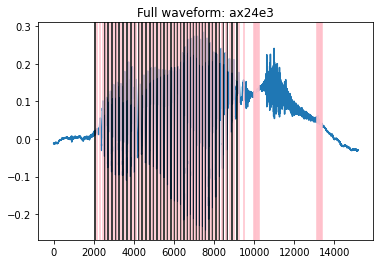

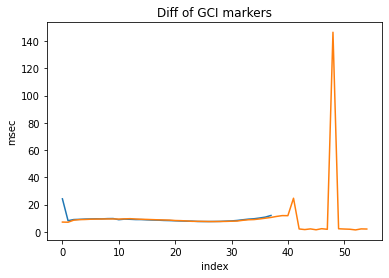

array([ 8.2 ,  9.05,  9.2 ,  9.4 ,  9.5 ,  9.6 ,  9.55,  9.75,  9.8 ,
        8.95,  9.35,  9.25,  9.05,  9.05,  8.85,  8.7 ,  8.6 ,  8.4 ,
        8.3 ,  8.15,  8.  ,  7.9 ,  7.9 ,  7.65,  7.6 ,  7.6 ,  7.65,
        7.7 ,  7.9 ,  8.05,  8.4 ,  8.9 ,  9.35,  9.65, 10.2 , 10.85,
       12.05])

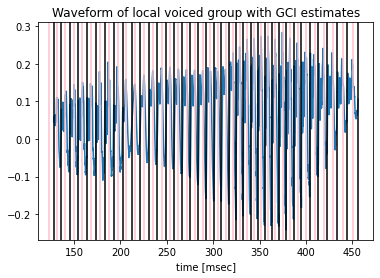

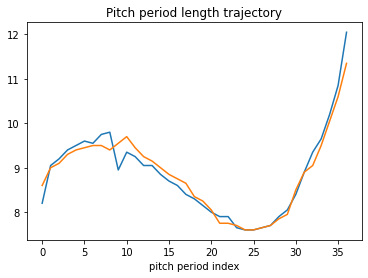

In [3]:
key = recordings.random_key()

k, m = period.load_recording_and_markers(recordings, markings, key)
pulses = praat.get_pulses(k.s, k.fs)
f = 1000/k.fs

title(f'Full waveform: {key}')
plot(k.s)
for p in m: axvline(p, color='black')
for p in pulses: axvline(p, color='pink')
#xlim(1800, 2300)
show()

figure()
title('Diff of GCI markers')
plot(diff(m)*f)
plot(diff(pulses)*f)
ylabel('msec')
xlabel('index')
show()

MIN_NUM_PERIODS = 3

voiced_groups = period.split_markings_into_voiced_groups(
    m, k.fs, constants.MAX_PERIOD_LENGTH_MSEC, MIN_NUM_PERIODS
)

for group in voiced_groups:
    if len(group) <= MIN_NUM_PERIODS + 1: continue

    group_periods = np.diff(group)*f # msec
    display(group_periods)
    
    group, group_praat = period.align_and_intersect(group, pulses)
    assert len(group) == len(group_praat)
    if len(group) <= MIN_NUM_PERIODS + 1:
        continue

    praat_periods = np.diff(group_praat) / k.fs * 1000 # msec
    if np.any(praat_periods > constants.MAX_PERIOD_LENGTH_MSEC):
        # Discard this and continue; we assume user will never accept
        # such Praat estimates so we don't want to model this case.
        warnings.warn(
            f'Discarded voiced group of GCIs because one of the synced '
            f'Praat periods is longer than {constants.MAX_PERIOD_LENGTH_MSEC} msec'
        )
        continue
    
    figure()
    title('Waveform of local voiced group with GCI estimates')
    t = np.arange(group[0], group[-1])
    plot(t*f, k.s[group[0] : group[-1]])
    for p in group: axvline(p*f, color='black')
    for p in group_praat: axvline(p*f, color='pink')
    xlabel('time [msec]')
    
    show()
    
    figure()
    title('Pitch period length trajectory')
    plot(np.diff(group) * f)
    plot(np.diff(group_praat) * f)
    xlabel('pitch period index')
    show()

## Plot marginal statistics

In [4]:
training_pairs = period.get_aplawd_training_pairs()

def plot_marginal(training_pairs, lab):
    true_marginal = []
    praat_marginal = []

    for true_group, praat_group in training_pairs:
        true_marginal.append(true_group)
        praat_marginal.append(praat_group)

    true_marginal = np.concatenate(true_marginal)
    praat_marginal = np.concatenate(praat_marginal)

    hist([true_marginal, praat_marginal], bins=50)
    xlabel(lab)
    
    return true_marginal, praat_marginal

[Memory]2.7s, 0.0min    : Loading get_aplawd_training_pairs...


Distribution of number of consecutive pitch periods in our training data.

,0
count,13952.000000
mean,38.543936
std,25.771295
min,4.000000
25%,19.000000
50%,37.000000
75%,53.000000
max,314.000000


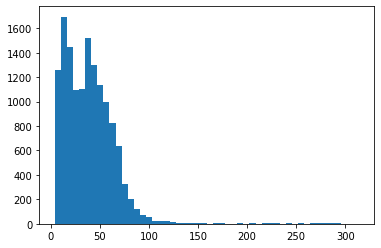

In [5]:
len_data_points = np.array([len(pair[0]) for pair in training_pairs])
hist(len_data_points, bins=50)
pd.DataFrame(len_data_points).describe()

,true,Praat
count,537765.000000,537765.000000
mean,7.141548,7.121436
std,2.191636,2.159969
min,2.050000,2.050000
25%,5.400000,5.400000
50%,6.900000,6.900000
75%,8.500000,8.500000
max,19.950000,19.950000


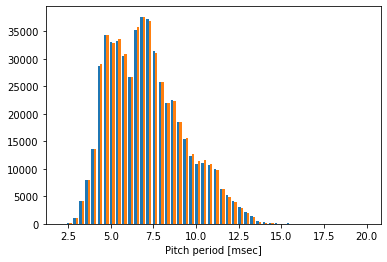

In [6]:
true_marginal, praat_marginal = plot_marginal(training_pairs, 'Pitch period [msec]')
pd.DataFrame({'true': true_marginal, 'Praat': praat_marginal}).describe()

## Select a subset for fitting

We randomly select 5000 samples to cut down inference time (since we do maximum likelihood anyway). We also limit the maximum number of pitch periods at 100 (= 98.68 percentile) to cut down inference time. This limits inference time for each kernel at around O(15) minutes.

In [7]:
data = period.get_aplawd_training_pairs()

[Memory]3.8s, 0.1min    : Loading get_aplawd_training_pairs...


In [8]:
pplen = [len(d[0]) for d in data]
np.quantile(pplen, .9868) # Cut data at 98.68 percentile

100.0

In [9]:
subset = period.get_aplawd_training_pairs_subset()
samples = [d[0][:,None] for d in subset]

bounds = jnp.array([
    constants.MIN_PERIOD_LENGTH_MSEC,
    constants.MAX_PERIOD_LENGTH_MSEC
])[None,:]

[Memory]4.7s, 0.1min    : Loading get_aplawd_training_pairs...


## Fitting the nonlinear coloring trajectory priors...

... i.e., transform the data to the "color" domain (i.e. where it is assumed to be distributed as a MVN) and fit a multi-output GP to it with an extra log det jacobian term coming from the nonlinear coloring transformation.

Remember that the mean and variance ($\sigma^2$) of the GP are not inferred but just directly estimated from the data with `get_log_stats()` (previous estimations showed the inferred values to be very close to the empirical estimated values). The only fitted values is the rescaling factor for $\sigma^2$ and the envelope GP's lengthscale and noise sigma.

In [10]:
VARIABLE_NAMES = ['s', 'envelope_lengthscale', 'envelope_noise_sigma']

In [11]:
bijectors.get_log_stats(jnp.vstack(samples), bounds)

{'samples': array([[1.75785792],
        [1.85629799],
        [1.84845481],
        ...,
        [2.45958884],
        [2.4765384 ],
        [2.50143595]]),
 'bounds': array([[0.69314718, 2.99573227]]),
 'mean': array([1.93108163]),
 'cov': array([[0.091735]]),
 'sigma': array([0.30287786]),
 'corr': array([[1.]]),
 'L_corr': array([[1.]])}

**Note: prior: our lognormal prior should really be base $10$, not base $e$; this gives a much better dynamic range which is expected a priori. This leads to faster nested sampling and lower information from prior to posterior.**

Given $Z \sim N(0,1)$, then our lognormal variable is 
$$X = 10^{\mu+\sigma Z} = e^{\log{10}(\mu+\sigma Z)}$$ so use regular lognormal with both $\mu$ and $\sigma$ scaled by $\log 10$.

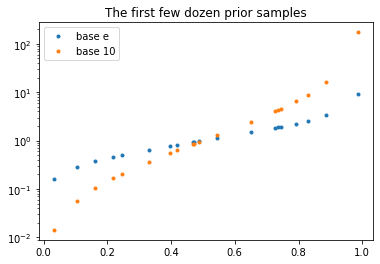

In [12]:
from scipy.stats import lognorm

lognorm_e  = lognorm(1.)
lognorm_10 = lognorm(np.log(10))

# We want our first few draws to scan out a realistic range
u= sorted(rand(20))

plot(u,lognorm_e.ppf(u), '.', label='base e')
plot(u,lognorm_10.ppf(u), '.', label='base 10')
yscale('log')
title('The first few dozen prior samples')
legend();

### The actual fits

**Matern 3/2 is the best fit by evidence with a large lengthscale of about 30.** The lengthscales $\lambda$ decrease with $\nu$: $\lambda(1/2) = 120, \lambda(3/2) = 30, \lambda(5/2) = 20, \lambda(\infty) = 10$.

The estimated values of the GP variance is $\sigma = 0.30 \rightarrow \sigma^2 = 0.09$.

The envelope noise sigma (in the colored domain) is about $\sigma_n = 0.010 \rightarrow \sigma_n^2 = 0.0001$, so the envelope noise sigma is about a 1000 times smaller, which indicates a reasonable fit.

The **Praat observation error** fit is also simply estimated empirically as the variance of the error between Praat's estimates of the period trajectories and the ground truth trajectories. (The GP model for the true GCI markings is independent of the Praat observation model.)

This gives $\sigma_o = 0.067 \rightarrow \sigma_o^2 = 0.0044$, so several times larger than the envelope noise sigma, but still less that the GP variance $\sigma^2$. This corresponds roughly to a relative uncertainty in the natural (msec) domain of $\rho = \sigma_o = 7\%$, which seems reasonable.

All of this indicates that while Praat gives noisy estimates, our fitted latent GP can still extract meaningful information from them by conditioning on them, because the GP variance is much larger than Praat's estimation noise, and the GP noise envelope (which characterizes the nonsmooth component) is meaningfully smaller.

In [13]:
period.fit_praat_estimation_sigma()

[Memory]24.4s, 0.4min   : Loading get_aplawd_training_pairs...
[Memory]25.2s, 0.4min   : Loading get_aplawd_training_pairs...
[Memory]40.6s, 0.7min   : Loading run_nested...
[Memory]42.0s, 0.7min   : Loading run_nested...
[Memory]43.4s, 0.7min   : Loading run_nested...
[Memory]44.9s, 0.7min   : Loading run_nested...


DeviceArray(0.06663445, dtype=float64)

[Memory]50.3s, 0.8min   : Loading run_nested...
Summary
nlive: 15
niter: 362
ncall: 3128
eff(%): 12.052
logz: -97747.617 +/-  1.116


None

'Information (bans)'

8.02825275323779

/home/marnix/thesis/py/venv/lib/python3.10/site-packages/dynesty/plotting.py:315: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


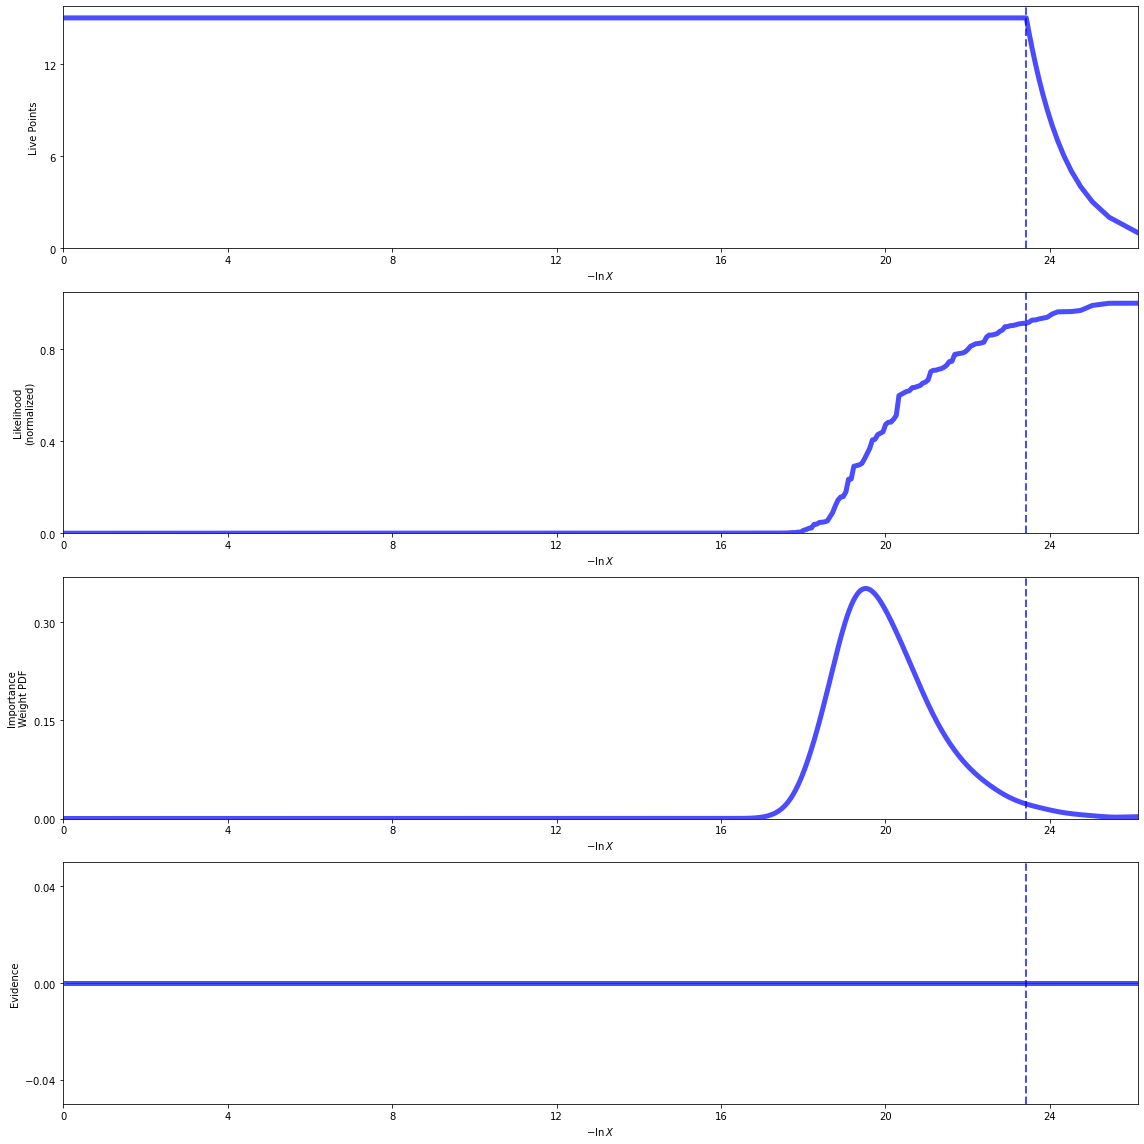

Quantiles:
s [(0.025, 1.248859542536474), (0.5, 1.2681145297116145), (0.975, 1.2870330318240477)]
Quantiles:
envelope_lengthscale [(0.025, 115.67807900477274), (0.5, 119.44808365447702), (0.975, 122.18395229670585)]
Quantiles:
envelope_noise_sigma [(0.025, 0.06984992792247514), (0.5, 0.07115299380472265), (0.975, 0.07255180924304515)]


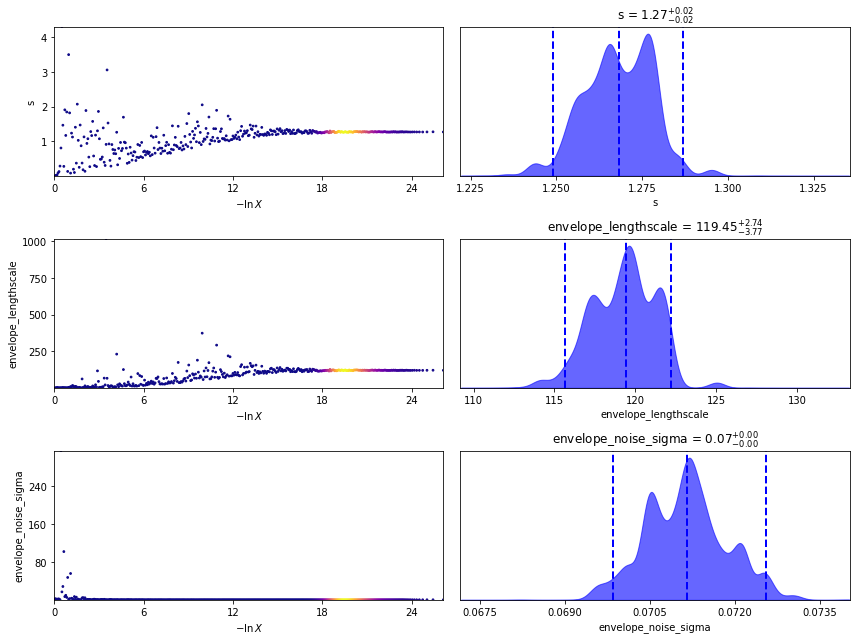

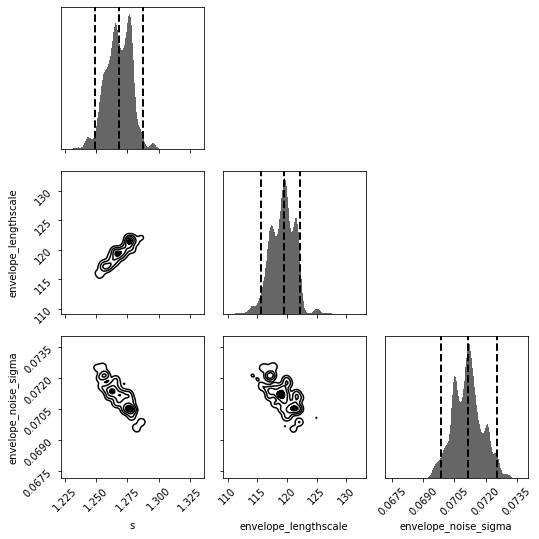

In [14]:
bijector, results = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    samples, bounds, "Matern12Kernel", 19863,
    return_fit_results=True
) # O(15) min

util.dyplot(results, VARIABLE_NAMES)

[Memory]54.0s, 0.9min   : Loading run_nested...
Summary
nlive: 15
niter: 360
ncall: 2920
eff(%): 12.842
logz: -87128.534 +/-  1.105


None

'Information (bans)'

7.887613812089172

/home/marnix/thesis/py/venv/lib/python3.10/site-packages/dynesty/plotting.py:315: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


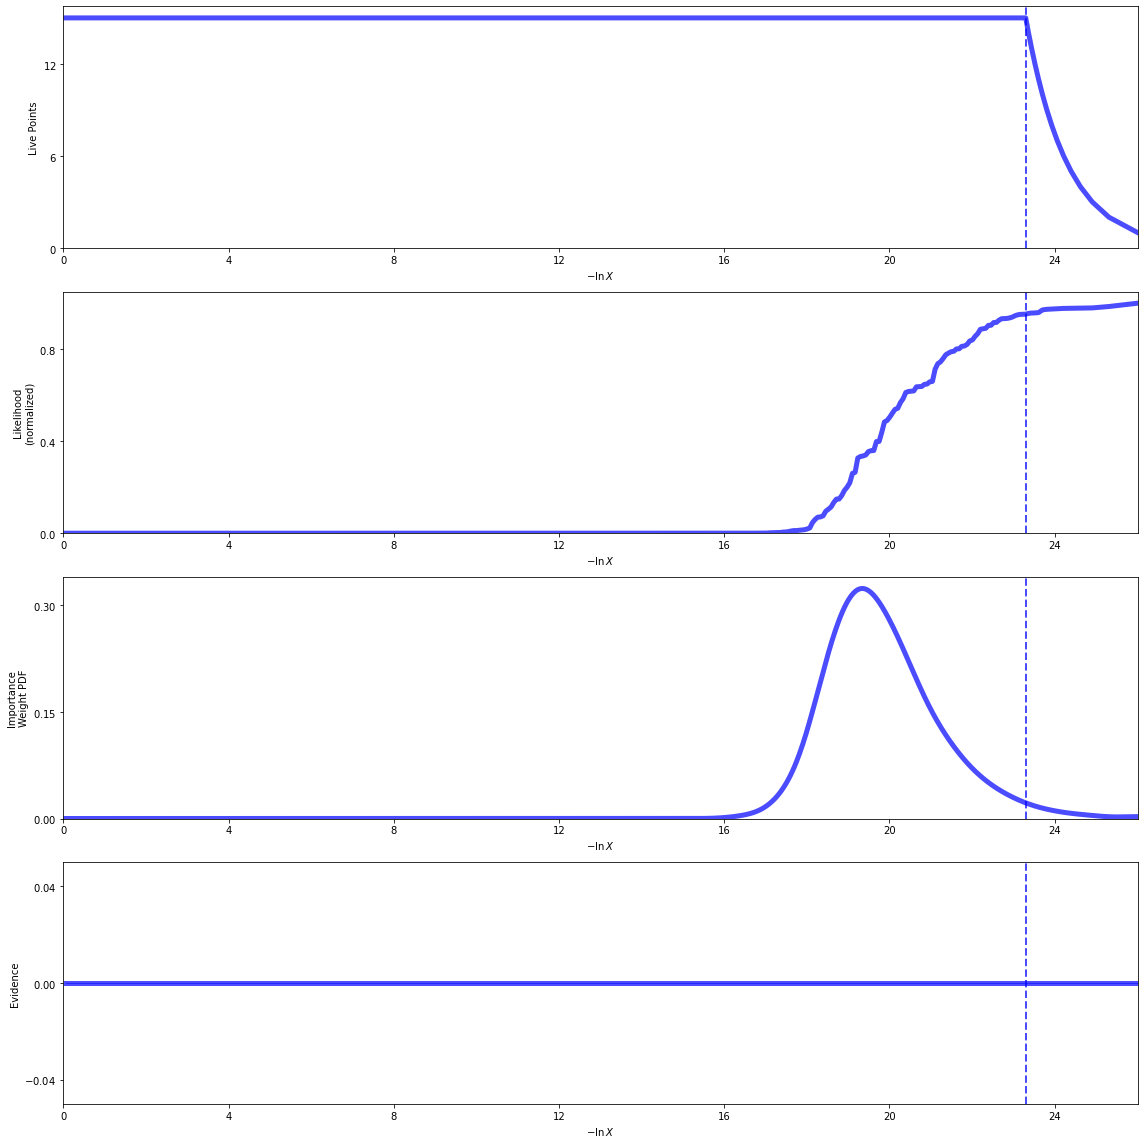

Quantiles:
s [(0.025, 1.4454295404895001), (0.5, 1.463808393257876), (0.975, 1.491059158014404)]
Quantiles:
envelope_lengthscale [(0.025, 28.688946812765078), (0.5, 29.15441783425721), (0.975, 29.720219222397848)]
Quantiles:
envelope_noise_sigma [(0.025, 0.09037205068205023), (0.5, 0.09191786552257525), (0.975, 0.09337190339786325)]


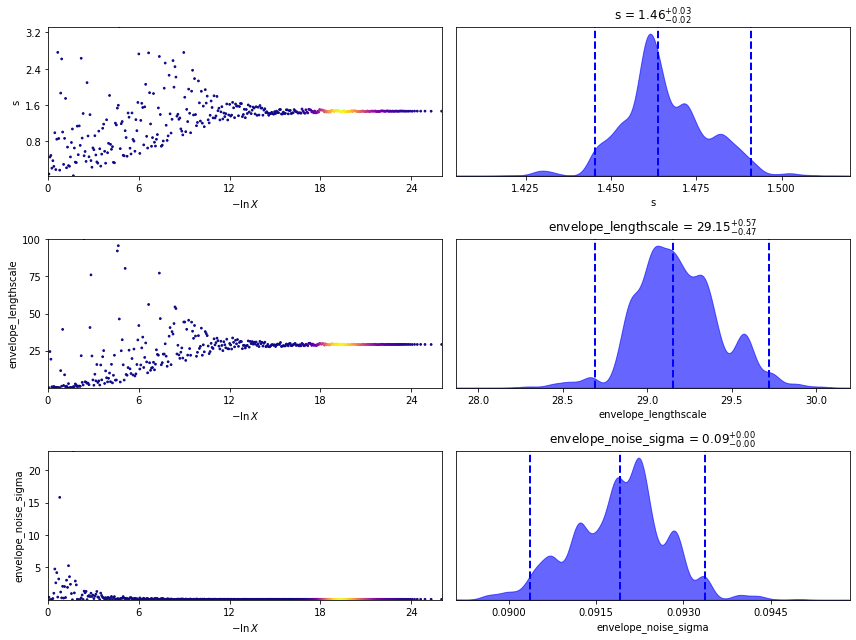

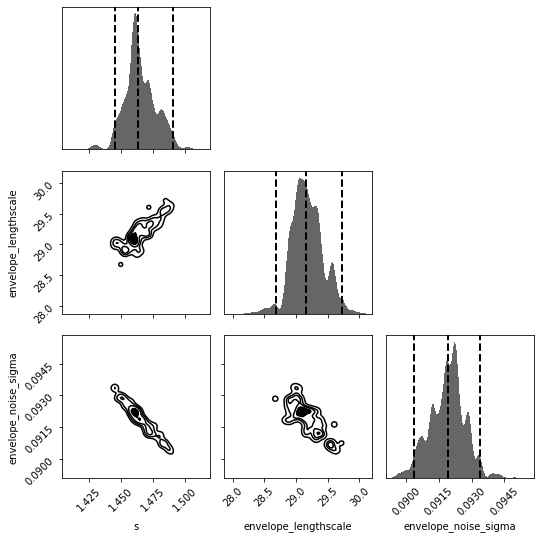

In [15]:
bijector, results = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    samples, bounds, "Matern32Kernel", 11279,
    return_fit_results=True
) # O(15) min

util.dyplot(results, VARIABLE_NAMES)

[Memory]58.0s, 1.0min   : Loading run_nested...
Summary
nlive: 15
niter: 361
ncall: 2857
eff(%): 13.161
logz: -87240.394 +/-  1.103


None

'Information (bans)'

7.858893544566441

/home/marnix/thesis/py/venv/lib/python3.10/site-packages/dynesty/plotting.py:315: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


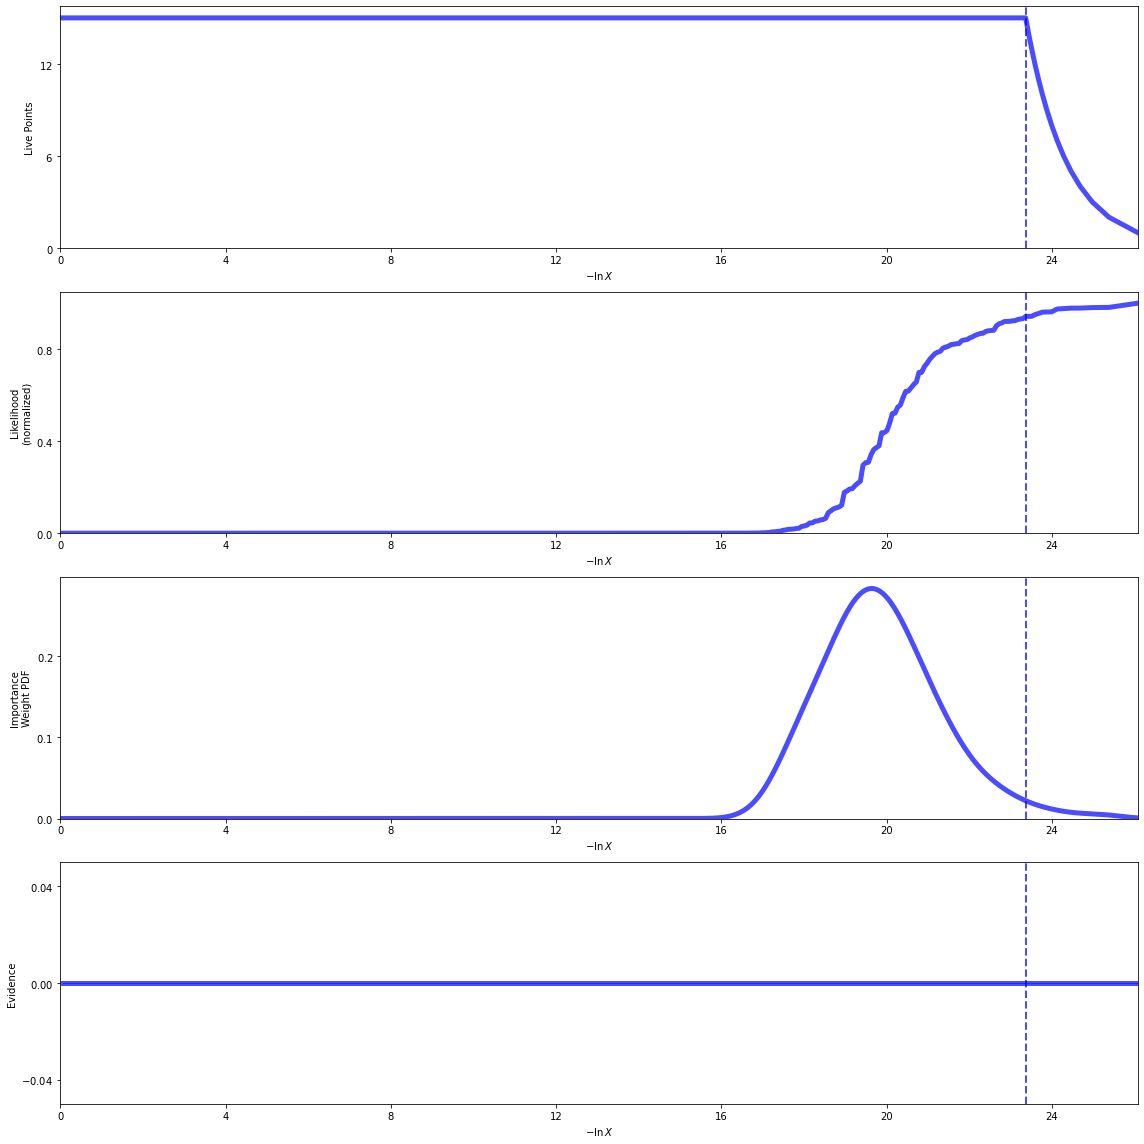

Quantiles:
s [(0.025, 1.3595653251806923), (0.5, 1.3807907038008231), (0.975, 1.402004564927297)]
Quantiles:
envelope_lengthscale [(0.025, 19.193661873568388), (0.5, 19.402360011401544), (0.975, 19.7033686689976)]
Quantiles:
envelope_noise_sigma [(0.025, 0.09856530508533226), (0.5, 0.09997328088829349), (0.975, 0.10162070213408243)]


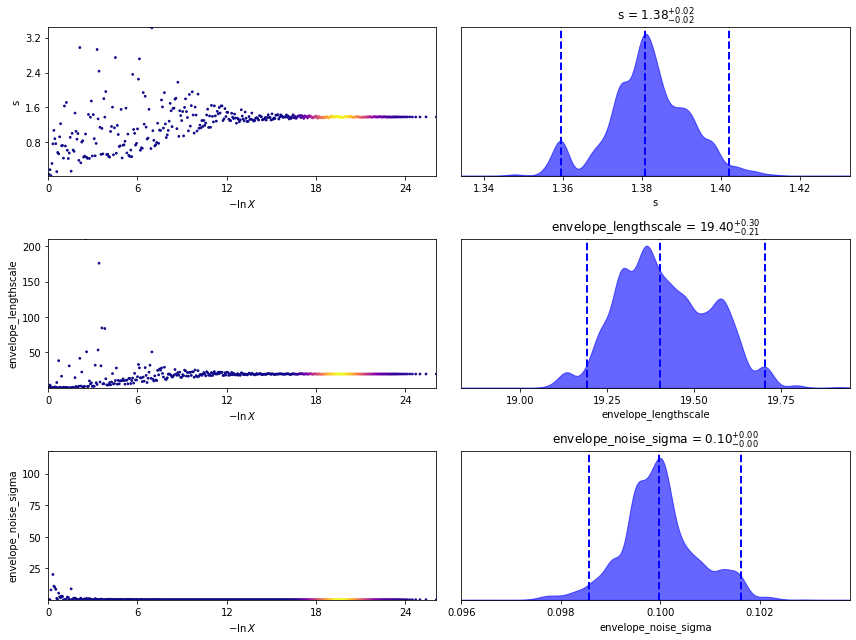

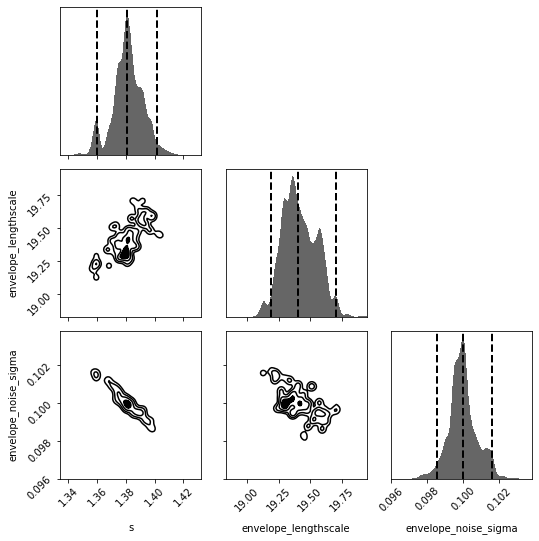

In [16]:
bijector, results = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    samples, bounds, "Matern52Kernel", 54697,
    return_fit_results=True
) # O(15) min

util.dyplot(results, VARIABLE_NAMES)

[Memory]61.8s, 1.0min   : Loading run_nested...
Summary
nlive: 15
niter: 342
ncall: 2784
eff(%): 12.823
logz: -89704.687 +/-  1.063


None

'Information (bans)'

7.299565451865206

/home/marnix/thesis/py/venv/lib/python3.10/site-packages/dynesty/plotting.py:315: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


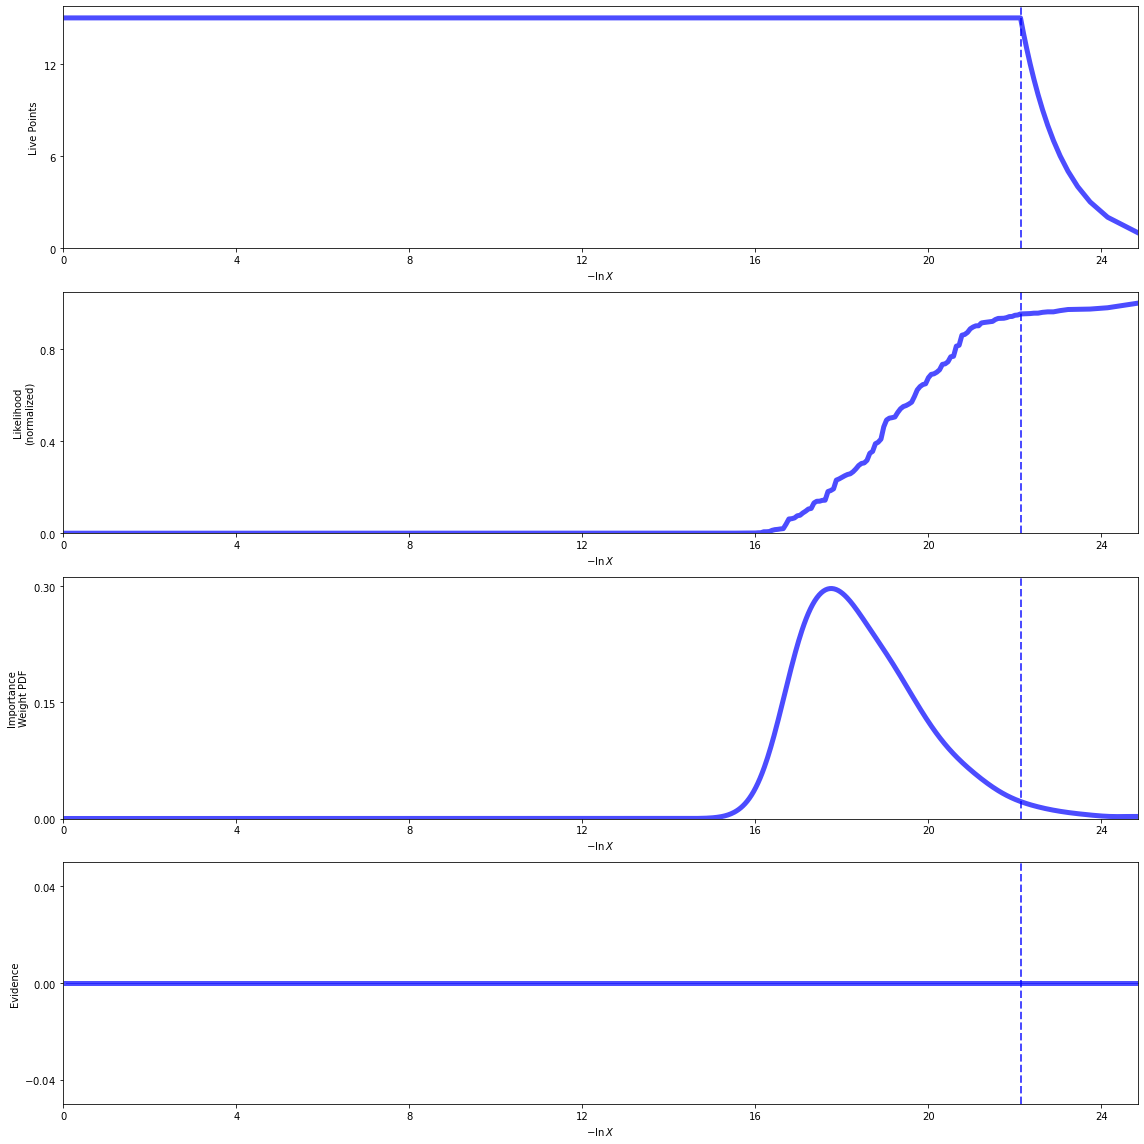

Quantiles:
s [(0.025, 1.268053450556619), (0.5, 1.2802901892536336), (0.975, 1.2949055125284161)]
Quantiles:
envelope_lengthscale [(0.025, 11.756033128460489), (0.5, 11.859432942878113), (0.975, 11.973224111167465)]
Quantiles:
envelope_noise_sigma [(0.025, 0.11020133914381326), (0.5, 0.1115322259100757), (0.975, 0.11312921675812955)]


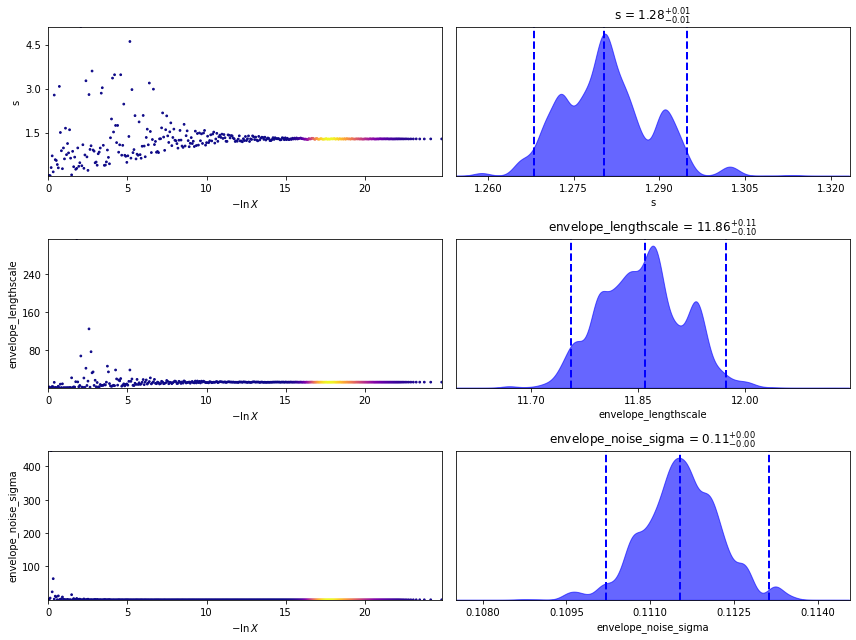

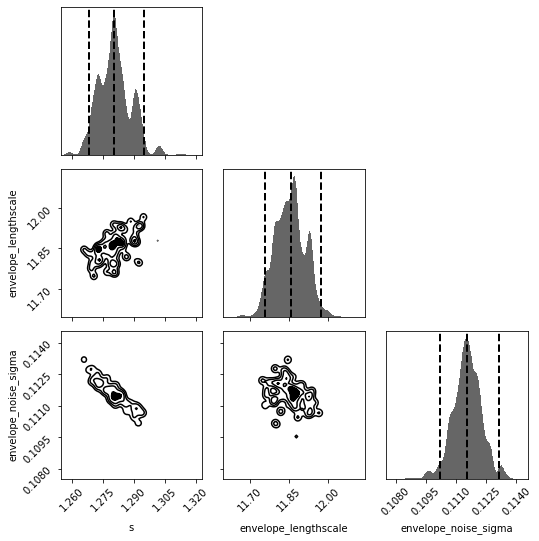

In [17]:
bijector, results = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    samples, bounds, "SqExponentialKernel", 79543,
    return_fit_results=True
) # O(15) min

util.dyplot(results, VARIABLE_NAMES)

## Check the fit

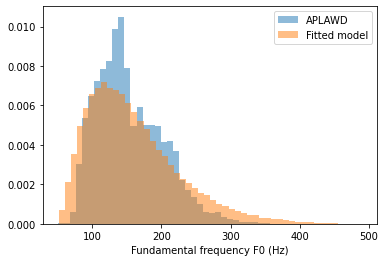

In [18]:
period_prior = period.period_marginal_prior()

samples = period_prior.sample(int(1e5), seed=jax.random.PRNGKey(50))

hist(1000/true_marginal, bins=50, alpha=.5, density=True, label='APLAWD');
hist(1000/np.asarray(samples), bins=50, alpha=.5, density=True, label='Fitted model');
legend()
xlabel('Fundamental frequency F0 (Hz)');

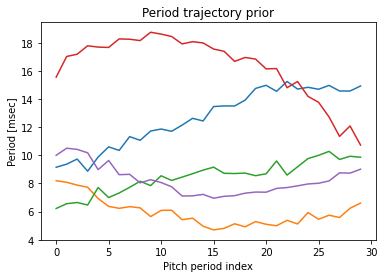

In [19]:
P = 30

prior = period.period_trajectory_prior(P)
samples = prior.sample(5, seed=jaxkey())
plot(samples.T)
xlabel('Pitch period index');
ylabel('Period [msec]');
title('Period trajectory prior');

## Conditioning on a Praat estimate

Praat $T$ estimation *mean* error is miniscule: less than 1%.

In [20]:
mean, cov = period.fit_praat_estimation_mean_and_cov()
mean

DeviceArray([-0.00259879], dtype=float64)

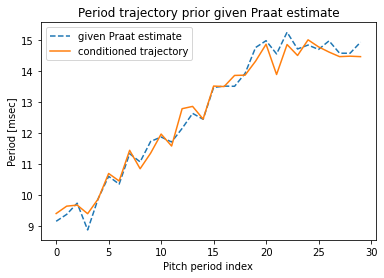

In [21]:
praat_estimate = samples[0,:]

prior = period.period_trajectory_prior(P, praat_estimate)
csamples = prior.sample(1, seed=jaxkey(48791))
plot(praat_estimate, '--', label="given Praat estimate")
plot(csamples.T, label="conditioned trajectory")
legend()
xlabel('Pitch period index');
ylabel('Period [msec]');
title('Period trajectory prior given Praat estimate');

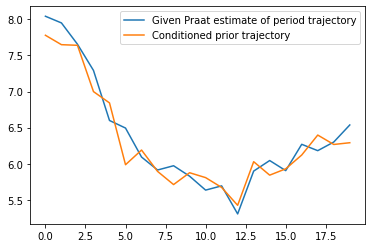

In [22]:
num_pitch_periods = 20

b = period.fit_period_trajectory_bijector(num_pitch_periods)

w1, w2 = randn(num_pitch_periods), randn(num_pitch_periods)
observation = b.forward(w1)

bc = bijectors.condition_nonlinear_coloring_trajectory_bijector(
    b, observation, cov
)

plot(observation, label="Given Praat estimate of period trajectory")
plot(bc.forward(w2), label="Conditioned prior trajectory")
legend();

### Measure jitter

The jitter implied by the prior is reasonably realistic. We use Praat's `jitter (local, absolute)` from <https://www.fon.hum.uva.nl/praat/manual/Voice_2__Jitter.html> because it is less sensitive to what we choose as a consistent group of pitch periods.

The natural jitter relates most clearly to the envelope noise sigma $\sigma_n$, but also to the kernel type and the GP variance $\sigma^2$. Indeed, since Matern 3/2 is preferred, there is a preference for some roughness, but not too much: this indicates the learning of a jitter component.

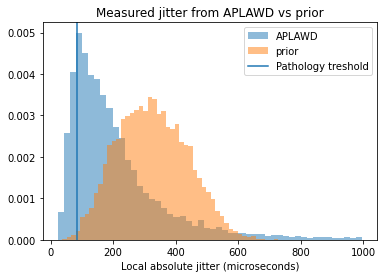

In [23]:
MAX_JITTER_USEC = 1000
NUM_SAMPLES = int(1e4)
NUMBINS = 50

# Measure APLAWD jitter over voiced groups
def measure_jitter(x):
    # https://www.fon.hum.uva.nl/praat/manual/PointProcess__Get_jitter__local__absolute____.html
    return float(np.mean(np.abs(np.diff(x))))

aplawd_jitter = np.array([measure_jitter(true_period) for (true_period, _) in training_pairs])
aplawd_jitter_usec = aplawd_jitter*1000
aplawd_jitter_usec = aplawd_jitter_usec[aplawd_jitter_usec < MAX_JITTER_USEC]

# Measure jitter from GP prior over one lengthscale
P = 30

prior = period.period_trajectory_prior(P)
samples = prior.sample(NUM_SAMPLES, seed=jax.random.PRNGKey(48712))

prior_jitter = np.mean(np.abs(np.diff(samples,axis=1)),axis=1)
prior_jitter_usec = prior_jitter*1000
prior_jitter_usec = prior_jitter_usec[prior_jitter_usec < MAX_JITTER_USEC]

# Plot
hist(aplawd_jitter_usec, bins=NUMBINS, alpha=0.5, density=True, label='APLAWD');
hist(prior_jitter_usec, bins=NUMBINS, alpha=0.5, density=True, label='prior');
axvline(83.200, label='Pathology treshold')
legend()
title('Measured jitter from APLAWD vs prior')
xlabel('Local absolute jitter (microseconds)');